In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
#Reading data
raw = mne.io.read_raw_nihon('/home/pablo/Documents/Universidad Data/Maestría en Matemáticas Aplicadas/Tesis/data/FA330022.EEG', preload=True)

Loading FA330022.EEG
Reading header from /home/pablo/Documents/Universidad Data/Maestría en Matemáticas Aplicadas/Tesis/data/FA330022.EEG
Reading 0 ... 299499  =      0.000 ...   598.998 secs...


/tmp/ipykernel_44819/1819702910.py:2: RuntimeWarning: No PNT file exists. Metadata will be blank
  raw = mne.io.read_raw_nihon('/home/pablo/Documents/Universidad Data/Maestría en Matemáticas Aplicadas/Tesis/data/FA330022.EEG', preload=True)
/tmp/ipykernel_44819/1819702910.py:2: RuntimeWarning: No LOG file exists. Annotations will not be read
  raw = mne.io.read_raw_nihon('/home/pablo/Documents/Universidad Data/Maestría en Matemáticas Aplicadas/Tesis/data/FA330022.EEG', preload=True)


In [3]:
#Pick only EEG channels
raw.pick_types(eeg=True, bio=False, misc=False)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,23 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,0.00 Hz
Lowpass,250.00 Hz


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().


Effective window size : 4.096 (s)


/tmp/ipykernel_44819/3880221071.py:6: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=50)
/home/pablo/Documents/Universidad Data/Maestría en Matemáticas Aplicadas/Tesis/environment/lib/python3.10/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


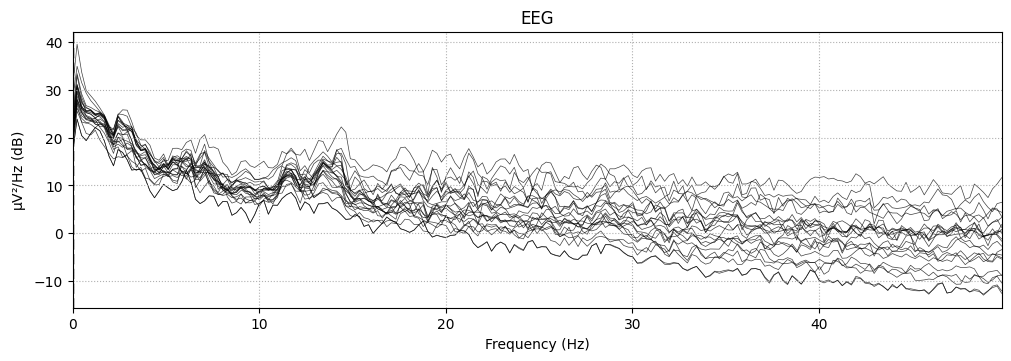

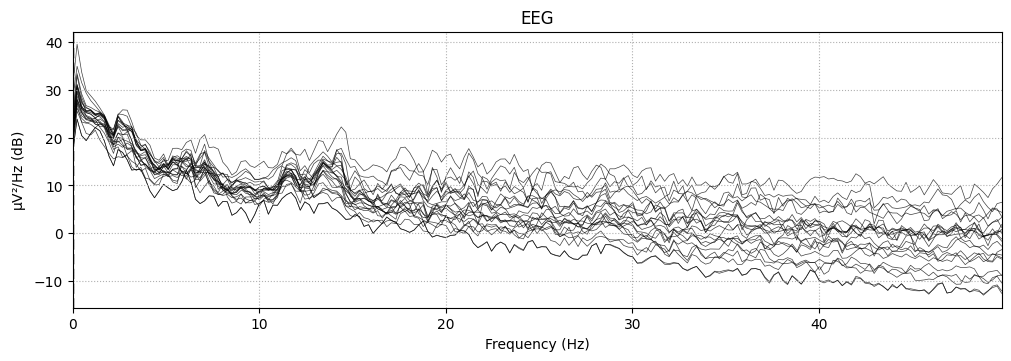

In [4]:
#Channels list
channels = raw.ch_names
channels_to_remove=['E']
raw.drop_channels(channels_to_remove)

raw.plot_psd(fmax=50)

In [5]:
# Step 4: Filtering
raw.filter(l_freq = 0, h_freq = 97.0)
# Set the frequency you want to remove; it's commonly 50 Hz or 60 Hz
notch_freq = 60  # or 60 for the USA and other countries using 60Hz
# Apply notch filter
raw.notch_filter(freqs = notch_freq)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 97 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 97.00 Hz
- Upper transition bandwidth: 24.25 Hz (-6 dB cutoff frequency: 109.12 Hz)
- Filter length: 69 samples (0.138 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,22 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,0.00 Hz
Lowpass,97.00 Hz


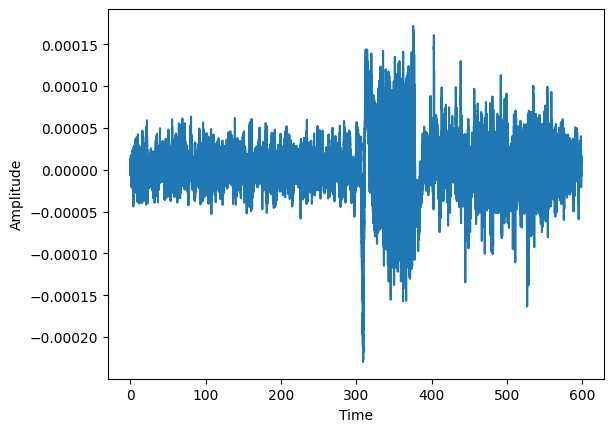

In [6]:
data=raw.get_data()[6]
#Sampling signal at 500 Hz
fs=500
#Sampling period
T=1/fs
#Length of signal
L=len(data)
#Time vector
t=np.arange(0,L)*T
#Plotting signal
plt.plot(t,data)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

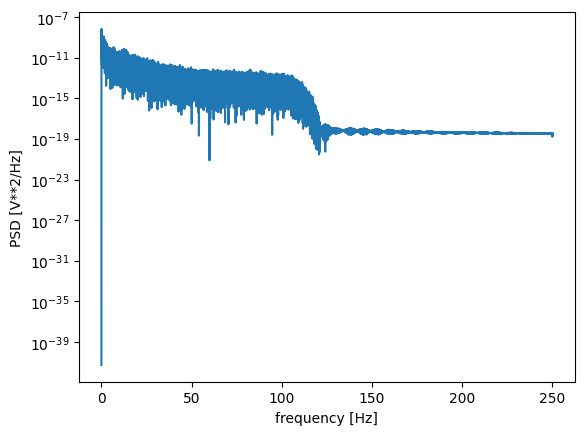

In [7]:
#Getting the energy spectral density gammma(w)=(X(w)*X(w))/2pi where X(w) is the fourier transform of x(t)
#and x(t) is the signal. Using the periodogram method
#Getting the periodogram of the signal data
f, Pxx_den = signal.periodogram(data,fs=raw.info['sfreq'],scaling='density')
#plotting the periodogram
plt.semilogy(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

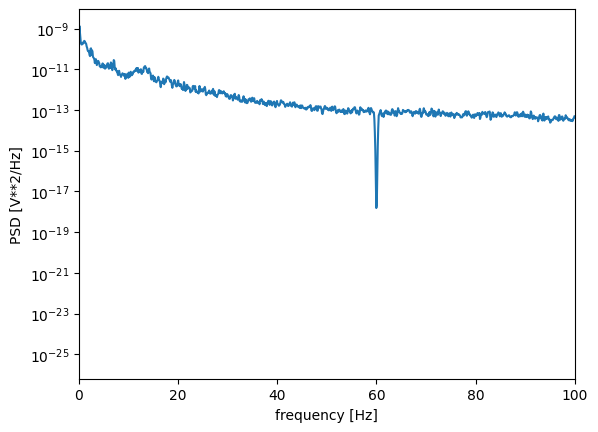

In [8]:
(f, S)= signal.welch(data, fs=raw.info['sfreq'], nperseg=1024*5)

plt.semilogy(f, S)
plt.xlim([0, 100])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

In [9]:
def calculate_ER(data, window_size, overlap):
    """
    Calculate time-varying Energy Ratio (ER) from Theta(w) using a sliding window.

    Parameters:
    - S: Periodogram estimate for Theta(w)
    - f: Frequency vector
    - window_size: Size of the sliding window in samples
    - overlap: Overlap between consecutive windows in samples

    Returns:
    - time_points: Array of time points corresponding to the center of each window
    - ER_values: Array of time-varying ER values
    """

    # Initialize empty arrays to store results
    time_points = []
    ER_values = []

    # Iterate through the signal with the sliding window
    for start in range(0, len(data) - window_size + 1, overlap):
        end = start + window_size
        #(f, S)= signal.welch(data[start:end], fs=raw.info['sfreq'], nperseg=1024*5)
        (f,S)=signal.periodogram(data[start:end],fs=raw.info['sfreq'],scaling='density')

        # Calculate energy in each frequency band for the current window
        ETheta = np.sum(S[np.where((f >= 3.5) & (f < 7.4))])
        EAlpha = np.sum(S[np.where((f >= 7.4) & (f < 12.4))])
        EBeta = np.sum(S[np.where((f >= 12.4) & (f < 24))])
        EGamma = np.sum(S[np.where((f >= 24) & (f <= 97))])

        # Calculate Energy Ratio (ER) for the current window
        ER = (EBeta + EGamma) / (ETheta + EAlpha)

        # Store results
        time_points.append((start + end) / 2)  # Use the center of the window as the time point
        ER_values.append(ER)

    return np.array(time_points), np.array(ER_values)

# Example usage

window_size = 5000#Adjust as needed
overlap = 1 # Adjust as needed
time_points, ER_values = calculate_ER(data, window_size, overlap)


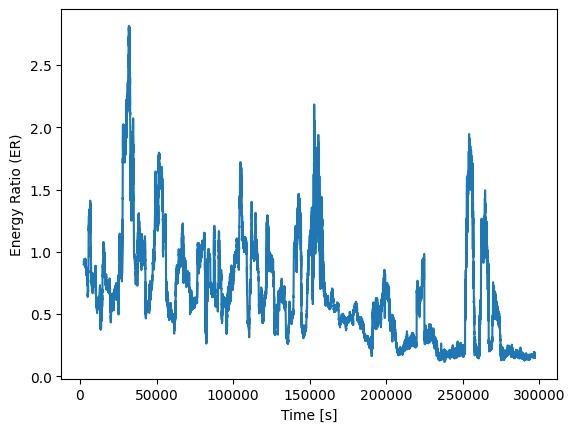

In [10]:
#Plotting the ER values
plt.plot(time_points, ER_values)
plt.xlabel('Time [s]')
plt.ylabel('Energy Ratio (ER)')
plt.show()


In [11]:
ER=ER_values
ER=(ER-np.min(ER))/(np.max(ER)-np.min(ER))
N=len(ER)
ER_n=(1/N)*np.sum(ER)
ER_n

0.20545323568265544

Now we are considering two different orientations. 
- To find an optimal lambda by runnig the code and selecting the lambda which gets the least amount of anomalies.
- A novel approach, considering the functional derivative and a sign function. With this in mind, take into account th deriate is high and states for a long time

Let's do it!

### First approach

lambda is  0
Total alarm times are  147932
Current best lambda is  0
Current best alarm times are  294501
-------------------
lambda is  100
Total alarm times are  131960
Current best lambda is  0
Current best alarm times are  147932
-------------------
lambda is  200
Total alarm times are  121215
Current best lambda is  100
Current best alarm times are  131960
-------------------
lambda is  300
Total alarm times are  111518
Current best lambda is  200
Current best alarm times are  121215
-------------------
lambda is  400
Total alarm times are  105678
Current best lambda is  300
Current best alarm times are  111518
-------------------
lambda is  500
Total alarm times are  97333
Current best lambda is  400
Current best alarm times are  105678
-------------------
lambda is  600
Total alarm times are  92429
Current best lambda is  500
Current best alarm times are  97333
-------------------
Best lambda is  600
Total alarm times are  92429


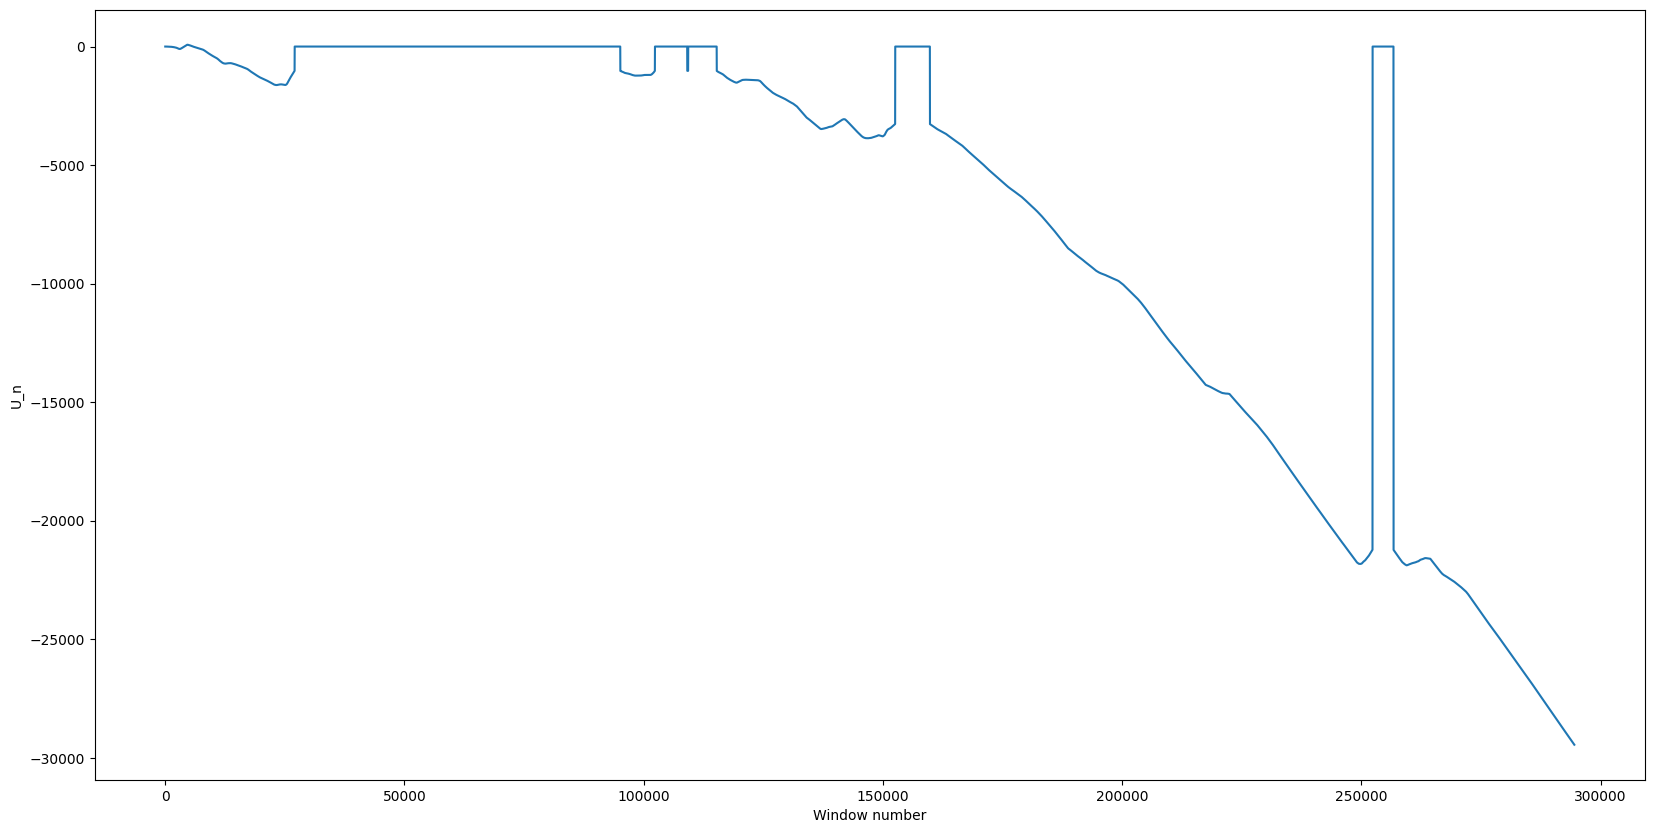

In [24]:
U_n=np.zeros(len(ER))

#Lambda is an array to explore the best value for the threshold
lambdas_=np.arange(0,700,100)
alarm_times=np.arange(0,len(ER),1)
best_lambda=0

for lambda_ in lambdas_:
    U_n_temp=np.zeros(len(ER))
    v=0.1   
    u_min=0 
    temp_alarm_times=[]
    print('lambda is ',lambda_)
    for i in range(N):
        U_n_temp[i]=np.sum(ER[0:i]-ER_n-0.1)
        u_min=np.min(U_n_temp)
        if (U_n_temp[i]-u_min)>lambda_:
            #print('Anomaly detected at window number ',i)
            temp_alarm_times.append(i)
            u_min=0
            U_n_temp[i]=0
    #We are trying to find the lambda which give the least amount of alamrm time, still >0
    print ('Total alarm times are ',len(temp_alarm_times))
    print ('Current best lambda is ',best_lambda)
    print ('Current best alarm times are ',len(alarm_times))
    print('-------------------')
    if len(temp_alarm_times)<len(alarm_times) and len(temp_alarm_times)>0:
        alarm_times=temp_alarm_times
        best_lambda=lambda_
        U_n=U_n_temp

            
        
#Putting a figure more larger in the x axis
print('Best lambda is ',best_lambda)
print ('Total alarm times are ',len(alarm_times))
plt.figure(figsize=(20,10))
plt.plot(U_n)
plt.xlabel('Window number')
plt.ylabel('U_n')
plt.show()

### Second approach

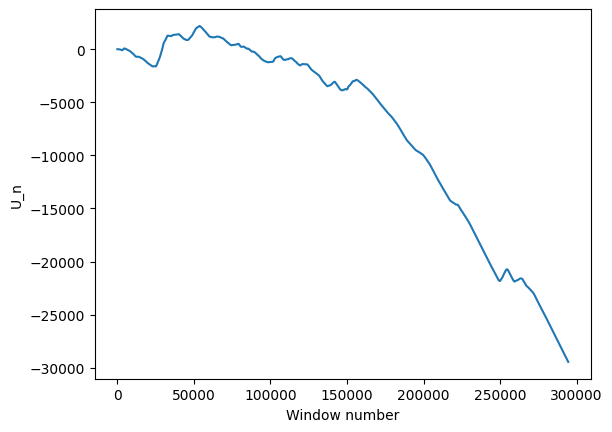

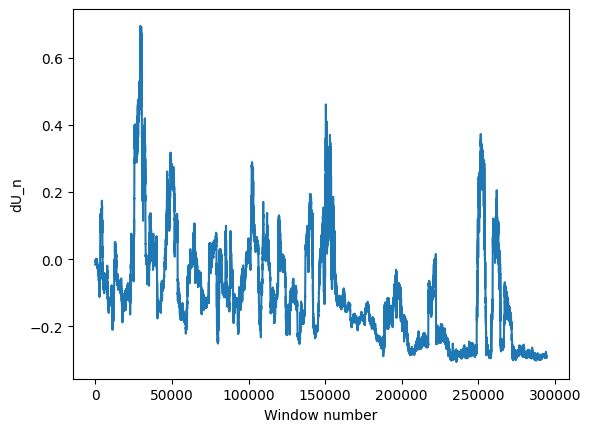

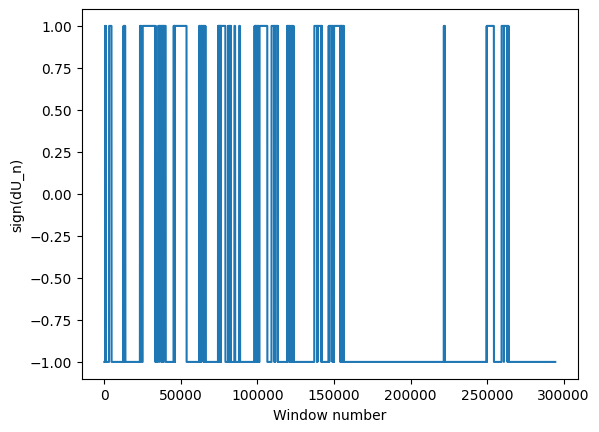

In [12]:
U_n=np.zeros(len(ER))
v=0.1
u_min=0
#lambda_=108867
lambda_=500
alarm_times=[]
for i in range(N):
    U_n[i]=np.sum(ER[0:i]-ER_n-0.1)
    u_min=np.min(U_n)
    if (U_n[i]-u_min)>lambda_:
        #print('Anomaly detected at window number ',i)
        alarm_times.append(i)

#Getting the derivative of the signal U_n
dt = 1 
dU_n=np.diff(U_n)/dt

#Plotting the signal U_n
plt.plot(U_n)
plt.xlabel('Window number')
plt.ylabel('U_n')
plt.show()

#Plotting the derivative of the signal U_n
plt.plot(dU_n)
plt.xlabel('Window number')
plt.ylabel('dU_n')
plt.show()

#Getting the sign of the derivative of the signal U_n
sign_dU_n=np.sign(dU_n)

#Plotting the sign of the derivative of the signal U_n
plt.plot(sign_dU_n)
plt.xlabel('Window number')
plt.ylabel('sign(dU_n)')
plt.show()



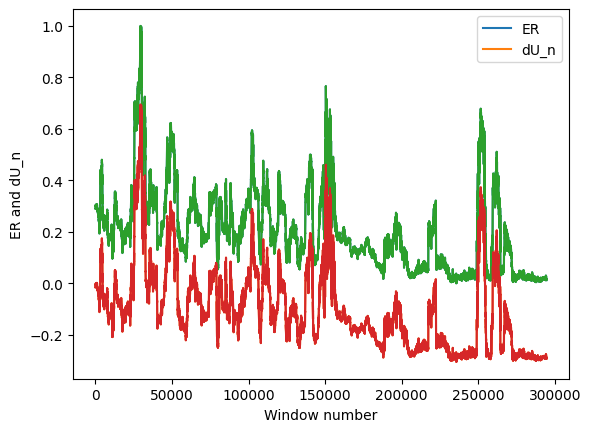

In [28]:
#Compare dU_n with the ER values
plt.plot(ER)
plt.plot(dU_n)
plt.xlabel('Window number')
plt.ylabel('ER and dU_n')
plt.legend(['ER','dU_n'])
plt.show()

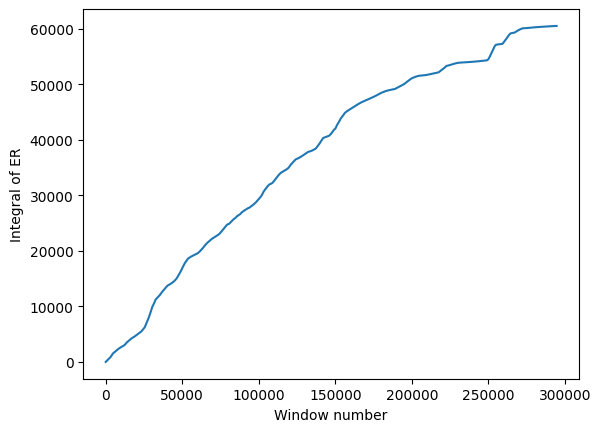

In [29]:
#Integral of ER
integral_ER=np.cumsum(ER)

#Plotting the integral of ER
plt.plot(integral_ER)
plt.xlabel('Window number')
plt.ylabel('Integral of ER')
plt.show()


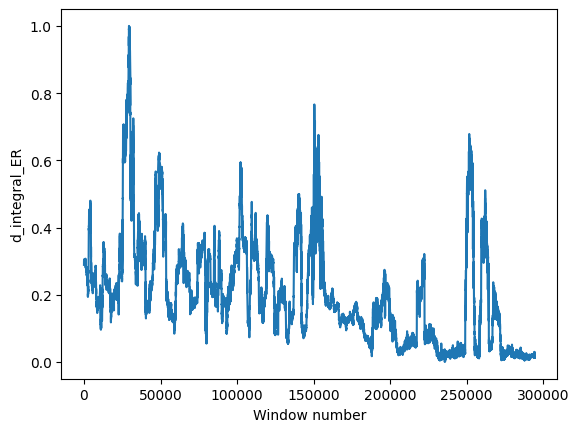

In [30]:
#Derivative of the integral of ER
d_integral_ER=np.diff(integral_ER)/dt

#Plotting the derivative of the integral of ER
plt.plot(d_integral_ER)
plt.xlabel('Window number')
plt.ylabel('d_integral_ER')
plt.show()


Since the derivative is almost equal to the original signal, the transformation is not giving us any sense of new information 

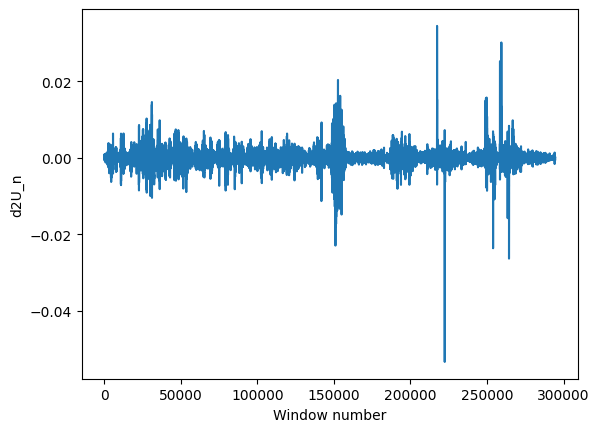

In [31]:
#Second derivative of ER from d_Un
d2U_n=np.diff(dU_n)/dt

#Plotting the second derivative of ER
plt.plot(d2U_n)
plt.xlabel('Window number')
plt.ylabel('d2U_n')
plt.show()


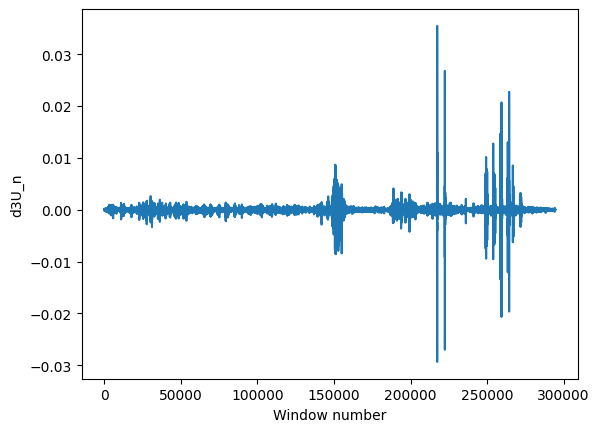

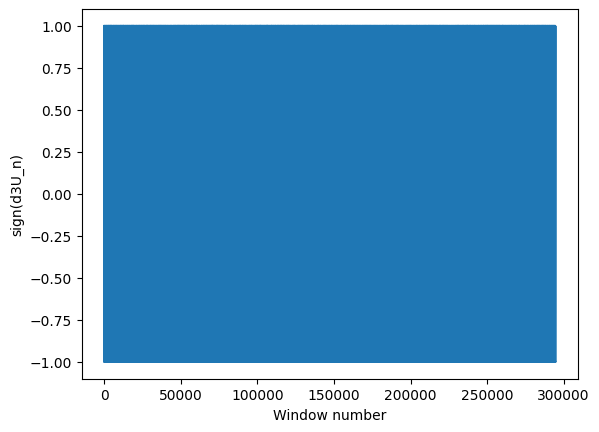

In [18]:
#Thrid derivative of ER from d2_Un
d3U_n=np.diff(d2U_n)/dt

#Sign of the third derivative of ER
sign_d3U_n=np.sign(d3U_n)


#Plotting the third derivative of ER
plt.plot(d3U_n)
plt.xlabel('Window number')
plt.ylabel('d3U_n')
plt.show()

#Plotting the sign of the third derivative of ER
plt.plot(sign_d3U_n)
plt.xlabel('Window number')
plt.ylabel('sign(d3U_n)')
plt.show()

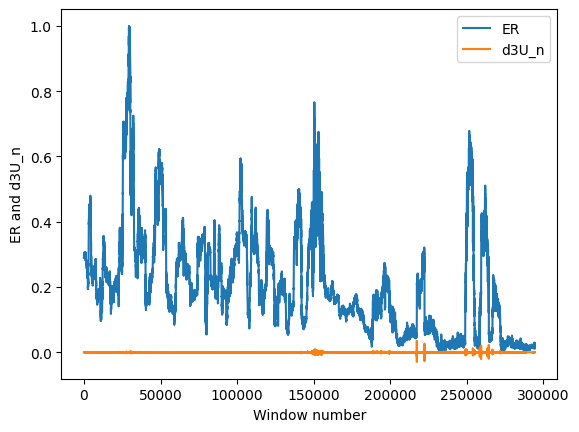

In [17]:
#plotting original signal and the third derivative of the signal both normalized
plt.plot(ER)
plt.plot(d3U_n)
plt.xlabel('Window number')
plt.ylabel('ER and d3U_n')
plt.legend(['ER','d3U_n'])
plt.show()


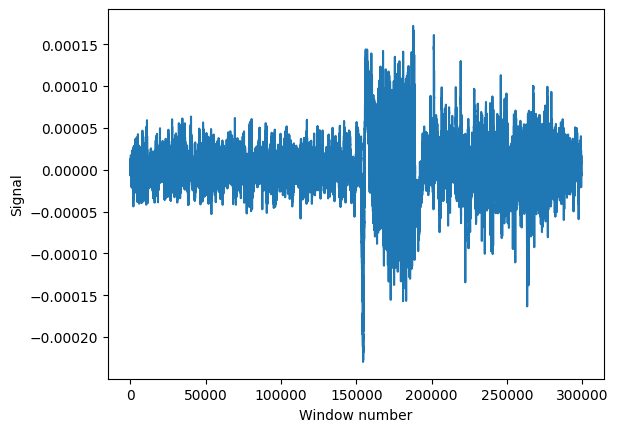

In [25]:
#ploting original signal 
plt.plot(data)
plt.xlabel('Window number')
plt.ylabel('Signal')
plt.show()

In [29]:
#The alarm time is the biggest value in the third derivative of the signal
alarm_time=np.argmax(d3U_n)
print('The alarm time is at window number ',alarm_time)

The alarm time is at window number  217393


### Basic Approach

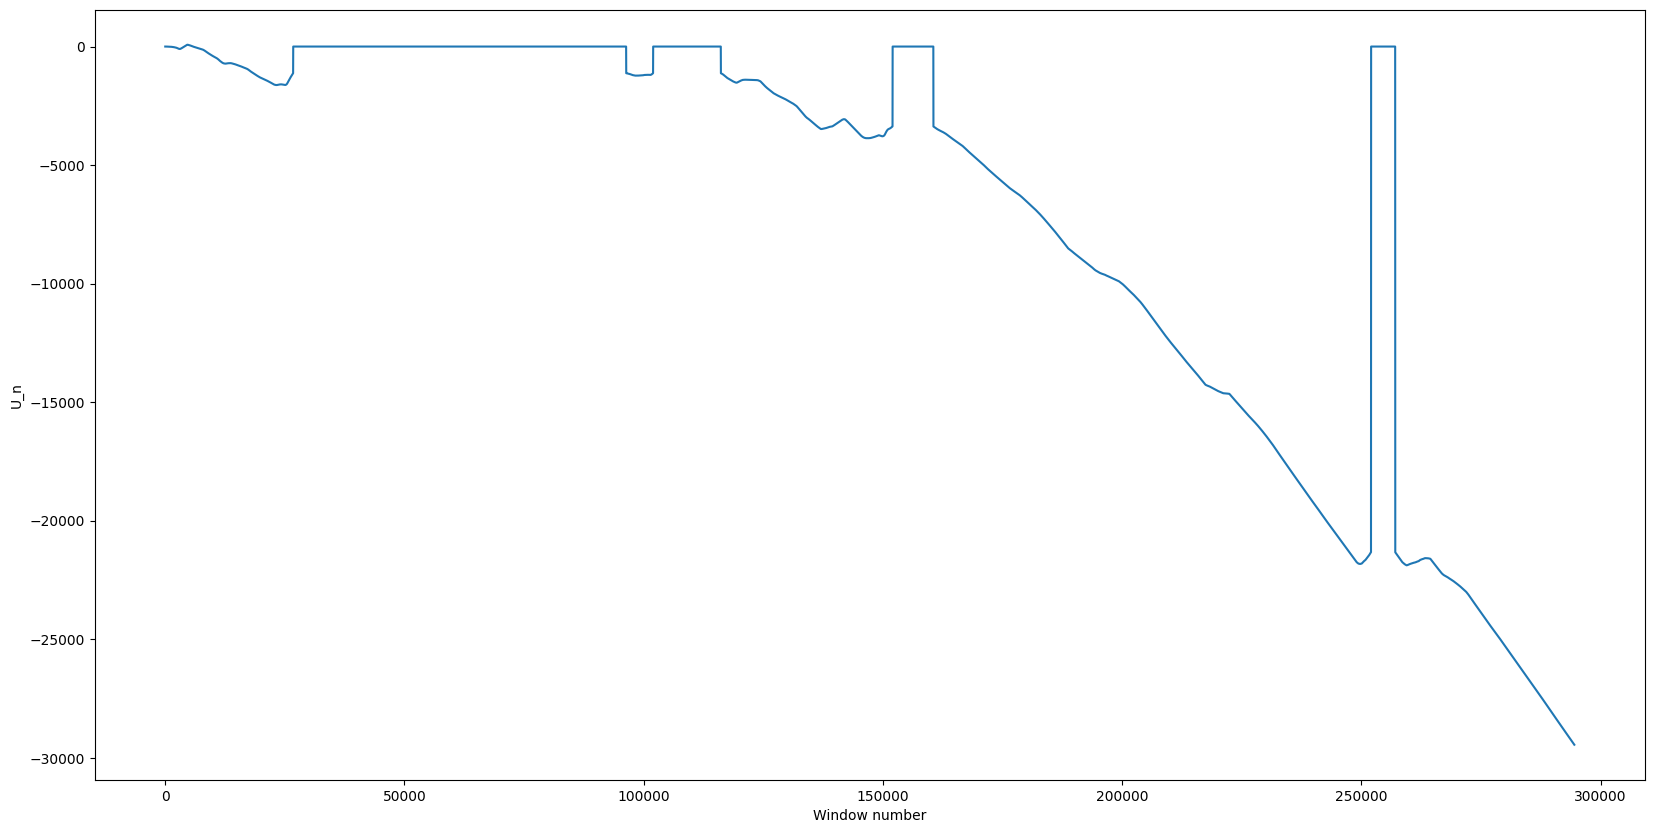

In [23]:
U_n=np.zeros(len(ER))
v=0.1
u_min=0
#lambda_=108867
lambda_=500
alarm_times=[]
for i in range(N):
    U_n[i]=np.sum(ER[0:i]-ER_n-0.1)
    u_min=np.min(U_n)
    if (U_n[i]-u_min)>lambda_:
        #print('Anomaly detected at window number ',i)
        alarm_times.append(i)
        u_min=0
        U_n[i]=0
#Putting a figure more larger in the x axis
plt.figure(figsize=(20,10))
plt.plot(U_n)
plt.xlabel('Window number')
plt.ylabel('U_n')
plt.show()

In [ ]:
- Causalidad 
- Libro de Vhalery
-
- Grafos con las demás medidas de conectividad

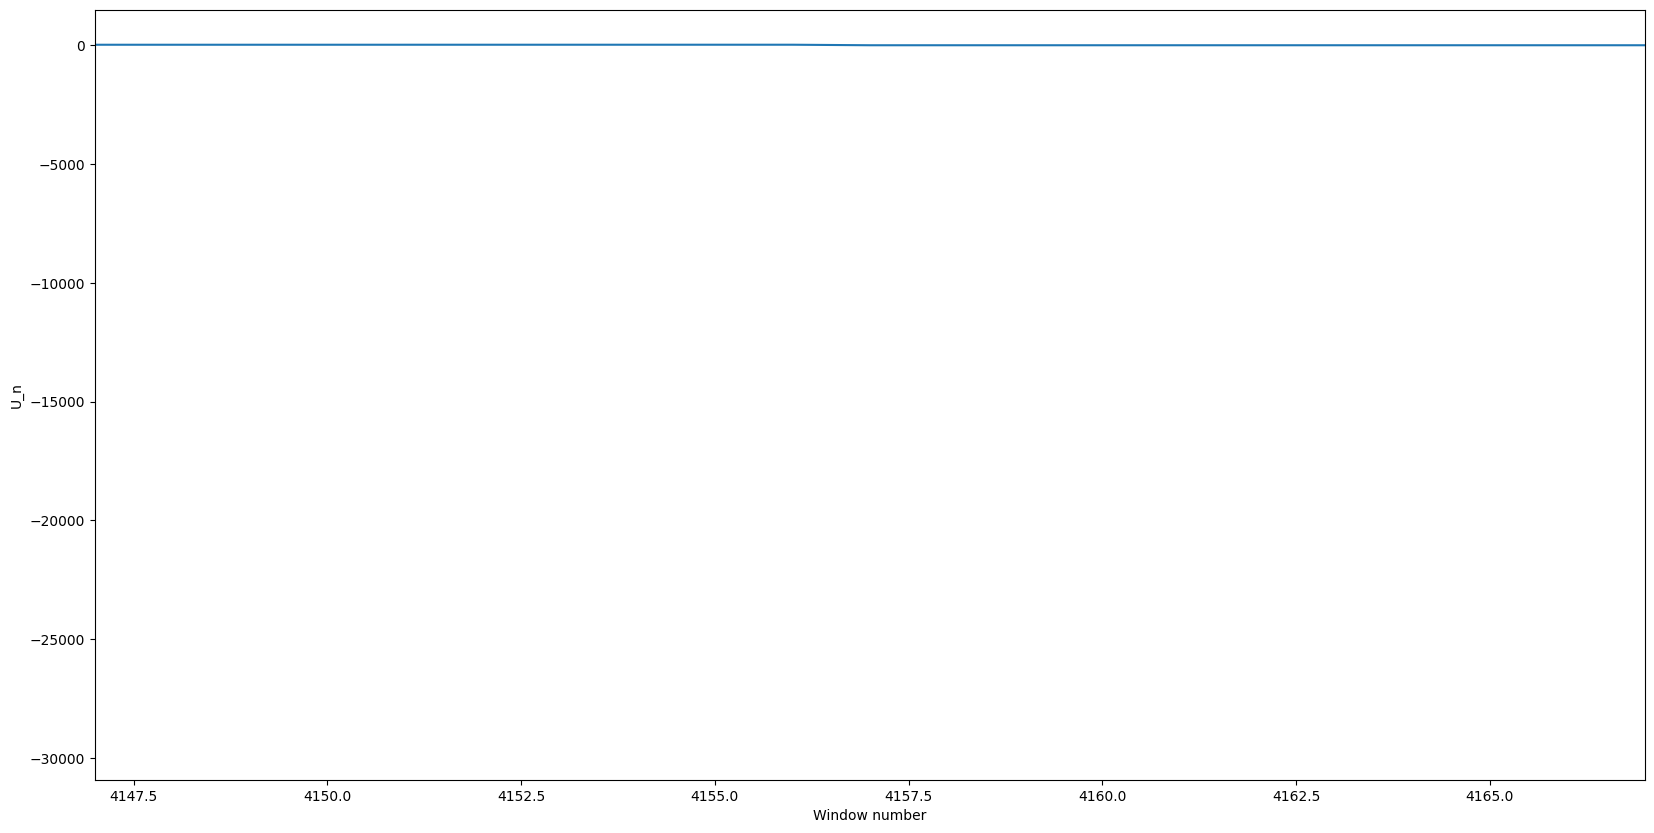

In [16]:
#Making a zoom in the alarm times
plt.figure(figsize=(20,10))
plt.plot(U_n)
plt.xlabel('Window number')
plt.ylabel('U_n')
plt.xlim([alarm_times[0]-10,alarm_times[0]+10])
plt.show()


The change points are:  [4157, 4158, 4159, 4160, 4161, 4162, 4163, 4164, 4165, 4166, 4167, 4168, 4169, 4170, 4171, 4172, 4173, 4174, 4175, 4176, 4177, 4178, 4179, 4180, 4181, 4182, 4183, 4184, 4185, 4186, 4187, 4188, 4189, 4190, 4191, 4192, 4193, 4194, 4195, 4196, 4197, 4198, 4199, 4200, 4201, 4202, 4203, 4204, 4205, 4206, 4207, 4208, 4209, 4210, 4211, 4212, 4213, 4214, 4215, 4216, 4217, 4218, 4219, 4220, 4221, 4222, 4223, 4224, 4225, 4226, 4227, 4228, 4229, 4230, 4231, 4232, 4233, 4234, 4235, 4236, 4237, 4238, 4239, 4240, 4241, 4242, 4243, 4244, 4245, 4246, 4247, 4248, 4249, 4250, 4251, 4252, 4253, 4254, 4255, 4256, 4257, 4258, 4259, 4260, 4261, 4262, 4263, 4264, 4265, 4266, 4267, 4268, 4269, 4270, 4271, 4272, 4273, 4274, 4275, 4276, 4277, 4278, 4279, 4280, 4281, 4282, 4283, 4284, 4285, 4286, 4287, 4288, 4289, 4290, 4291, 4292, 4293, 4294, 4295, 4296, 4297, 4298, 4299, 4300, 4301, 4302, 4303, 4304, 4305, 4306, 4307, 4308, 4309, 4310, 4311, 4312, 4313, 4314, 4315, 4316, 4317, 4318, 431

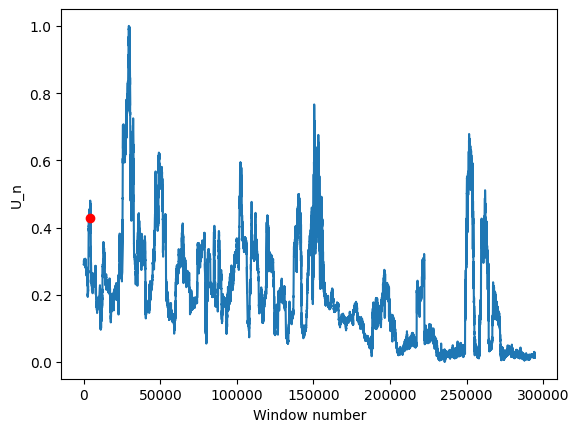

In [17]:

if len(alarm_times)==0:
    print("No change points found")
else:
    print("The change points are: ",alarm_times)
    plt.plot(ER)
    plt.xlabel('Window number')
    plt.ylabel('U_n')
    plt.plot(alarm_times[0],ER[alarm_times[0]],'ro')
    plt.show()

In [20]:
#Making a matrix of U_n, where the rows are every channel and the columns are the windows
#Getting the channels
channels = raw.ch_names
#Getting the number of channels
n_channels=len(channels)
#Getting the number of windows
n_windows=len(U_n)
#Making a matrix of zeros
U_n_matrix=np.zeros((n_channels,n_windows))
ER_matrix=np.zeros((n_channels,n_windows))
ER_n_array=np.zeros(n_channels)
#Alarm time array
alarm_time=np.zeros(n_channels)
#Detection time array
#detection_time=np.zeros(n_channels)
#A loop for every channel
for k in range(n_channels):
    #Getting the data of the channel
    data=raw.get_data()[k]
    #Getting the ER values
    time_points, ER_values = calculate_ER(data, window_size, overlap)
    ER=ER_values
    #Normalizing between 0 and 1
    ER=(ER-np.min(ER))/(np.max(ER)-np.min(ER))
    ER_matrix[k,:]=ER
    N=len(ER)
    ER_n=(1/N)*np.sum(ER)
    #Getting the ER_n values in the 
    ER_n_array[k]=ER_n
    ##Getting U_n
    U_n=np.zeros(len(ER))
    v=0.1
    u_min=0
    #lambda_=108867
    lambda_=125
    alarm_times=[]
    for i in range(N):
        U_n[i]=np.sum(ER[0:i]-ER_n-0.1)
        u_min=np.min(U_n)
        if (U_n[i]-u_min)>lambda_:
            #print('Anomaly detected at window number ',i, ' for channel ',k)    
            alarm_times.append(i)
            u_min=0
            U_n[i]=0
    #Saving the U_n values in the matrix
    U_n_matrix[k,:]=U_n
    #Getting the alarm time
    alarm_time[k]=alarm_times[0]
    

In [22]:
#Getting EI
N0=np.min(alarm_time)
Ei=[]
tau=1
#H variable is equal to 5 seconds, so 
H=5*fs
#sum from detection time to the end of the signal
for k in range(n_channels):
    Ei.append(((1/(alarm_time[k]-N0+tau))*np.sum(ER_matrix[k,int(alarm_time[k]):int(alarm_time[k]+H)])))
                                                 

In [23]:
Ei

[0.007195694864895854,
 0.0057846404716289405,
 0.0059055716623027865,
 0.010061157339589233,
 0.0839334931822579,
 0.0856953260935426,
 685.370864271415,
 42.92861920788444,
 0.015267465310428713,
 0.025778237633288847,
 0.030837334649613062,
 0.006744385269033702,
 0.012956827964461735,
 0.006705361452432367,
 0.011338064006326283,
 0.008644436390787992,
 0.007111098793807376,
 0.005527264251199616,
 0.011936636765846645,
 0.0115644576515741,
 0.016471167809914013,
 0.009890252819537412]

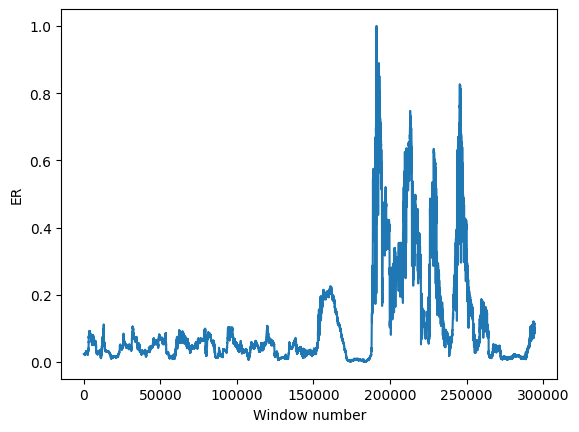

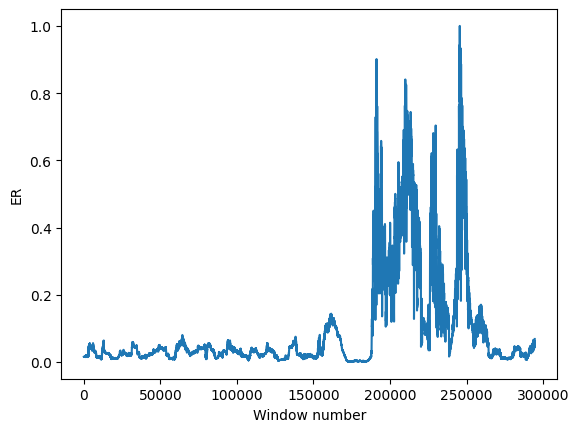

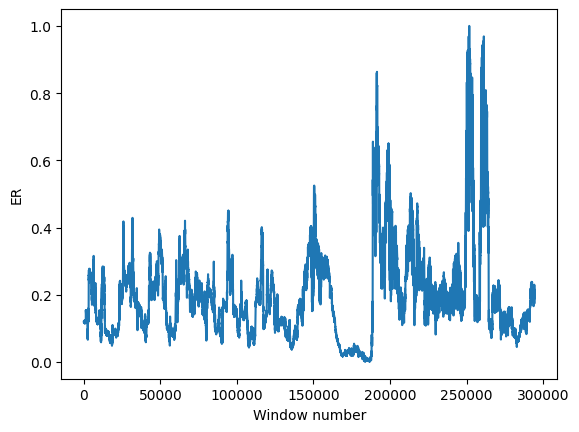

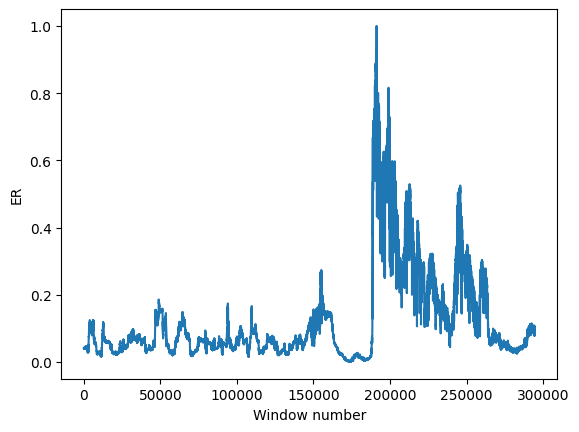

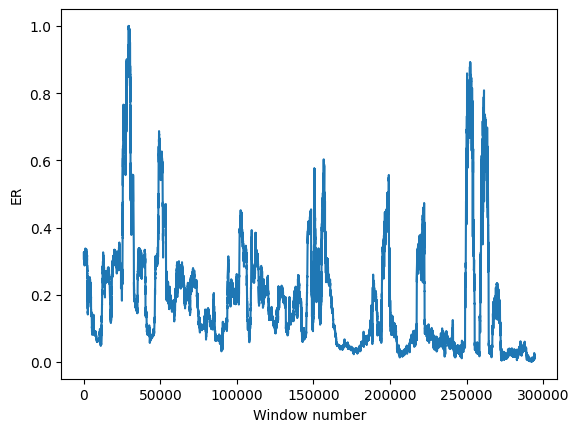

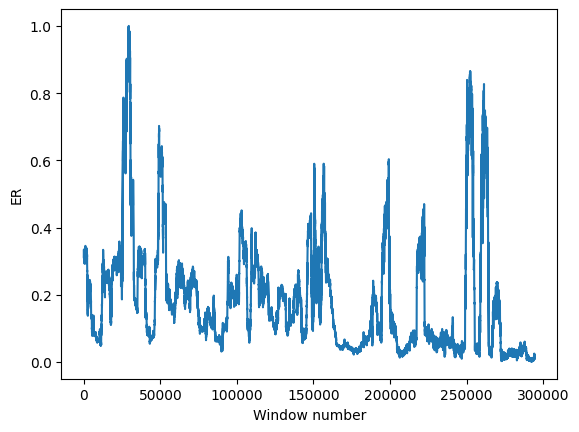

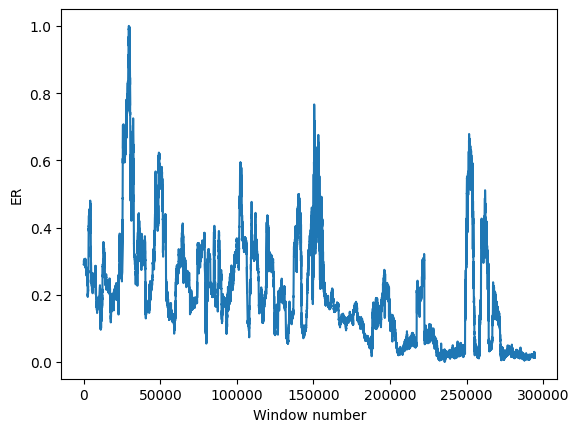

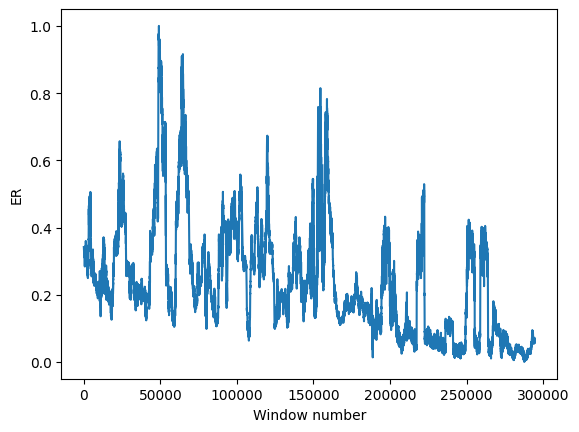

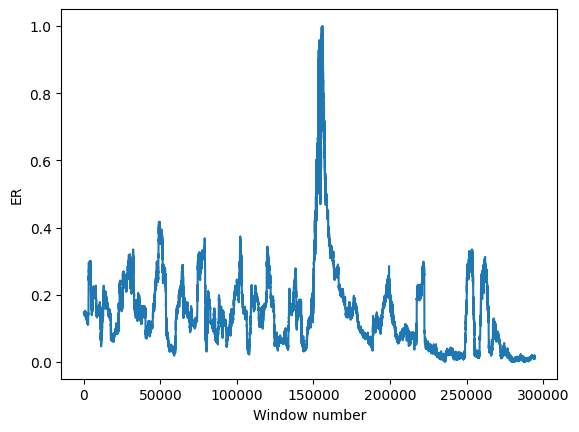

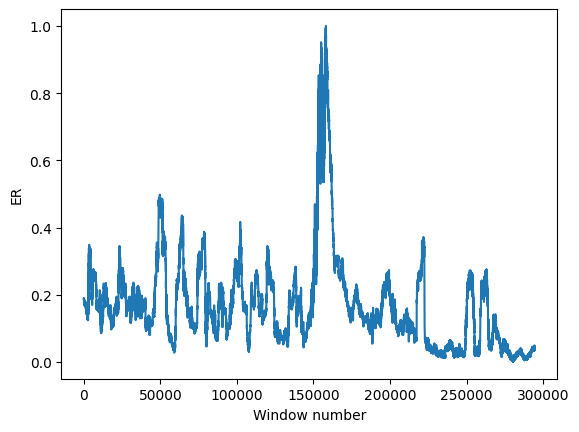

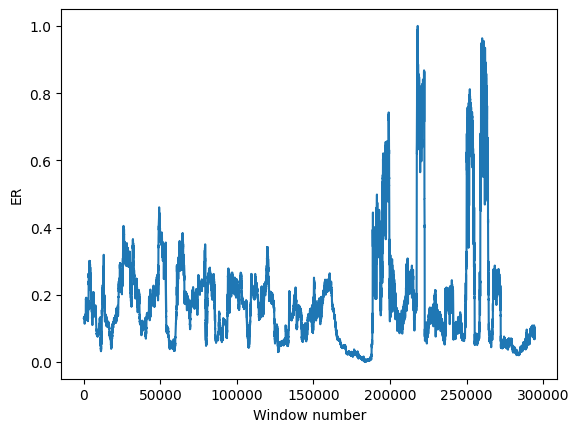

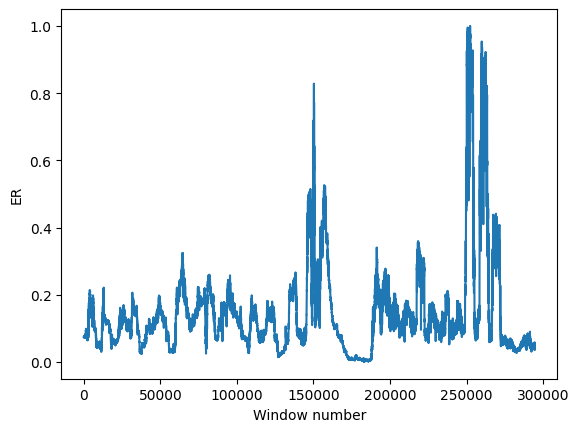

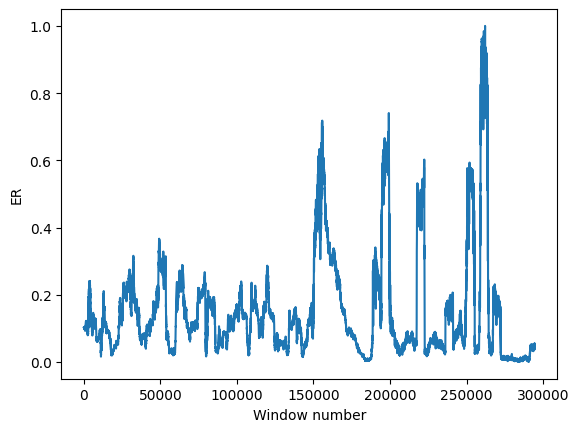

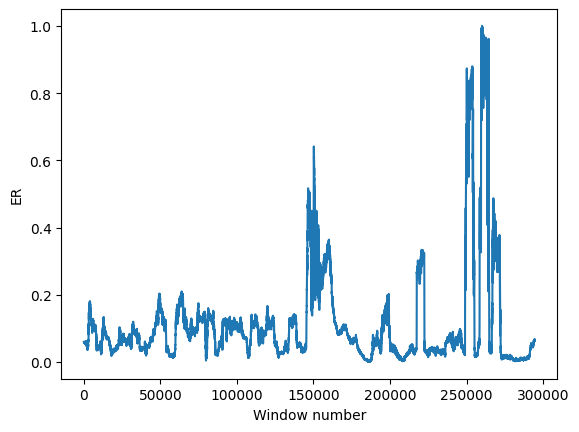

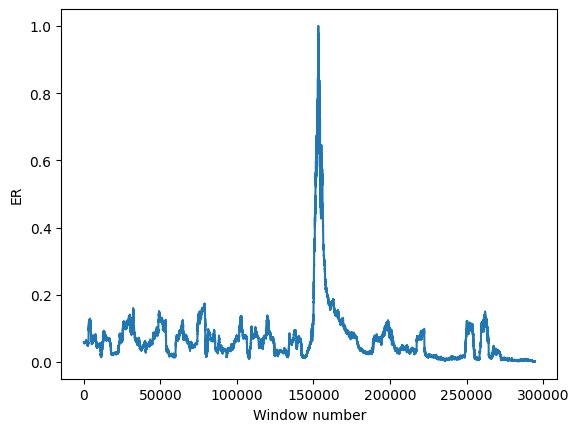

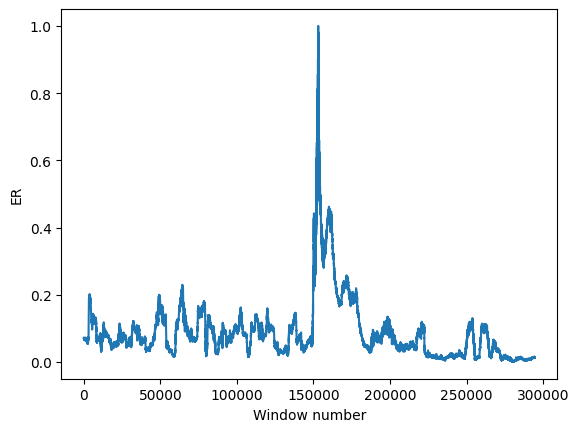

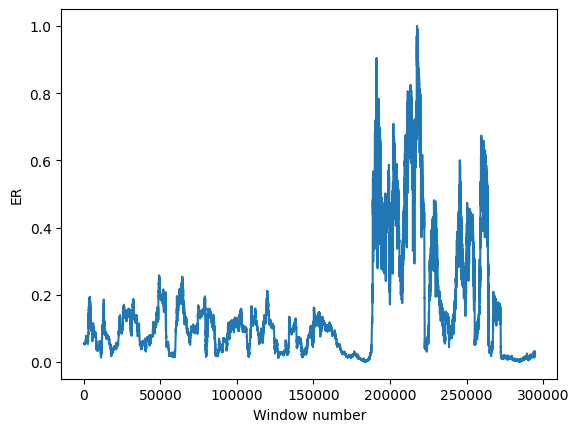

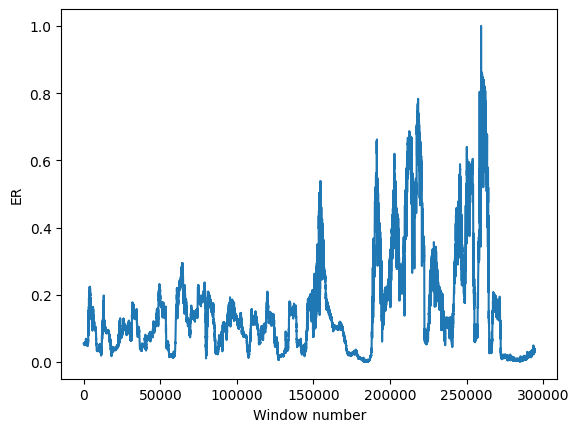

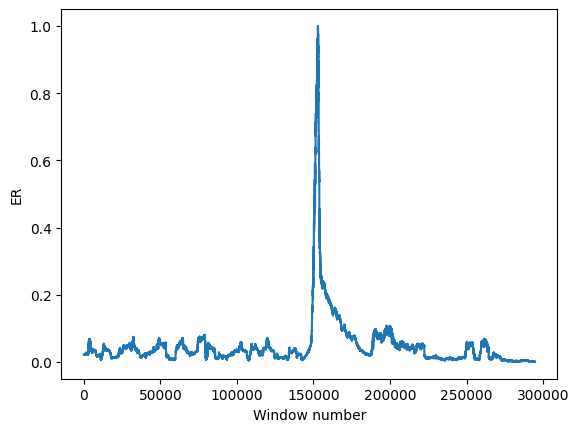

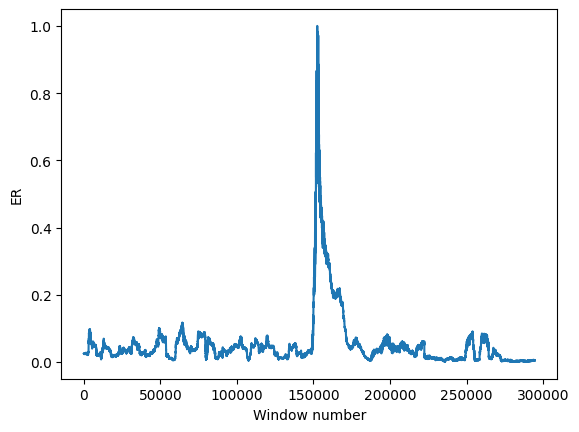

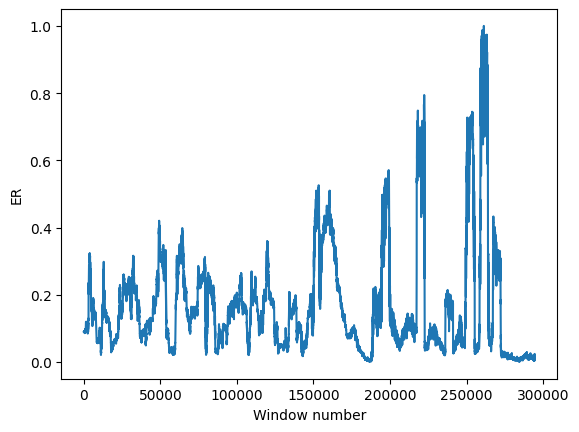

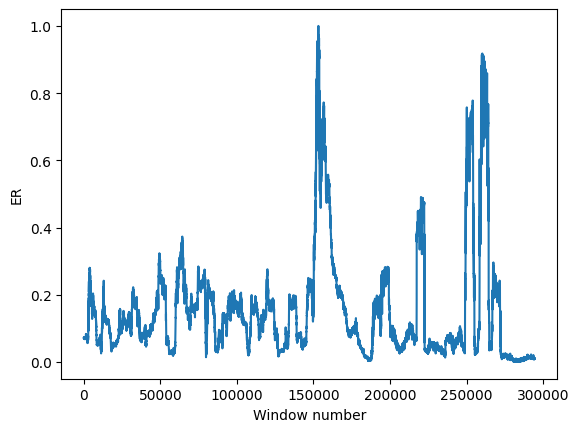

In [25]:
#Ploting the ER values for every channel
for k in range(n_channels):
    plt.plot(ER_matrix[k,:])
    plt.xlabel('Window number')
    plt.ylabel('ER')
    plt.show()

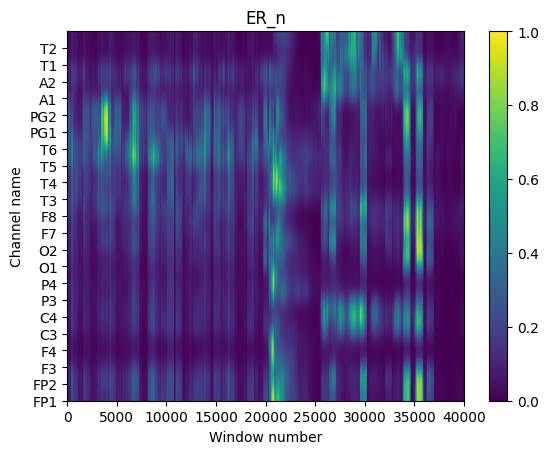

In [24]:
#Plotting the U_n values for every in a heatmap with an x axis of the window number and a y axis of the channel name with imshow variable "channels" as the labels
plt.imshow(ER_matrix,cmap='viridis',interpolation='bicubic',aspect='auto',extent=[0,40000,0,22])
#colorbar
plt.colorbar()
plt.yticks(np.arange(len(channels)), channels)
plt.xlabel('Window number')
plt.ylabel('Channel name')
plt.title('ER_n')
plt.show()

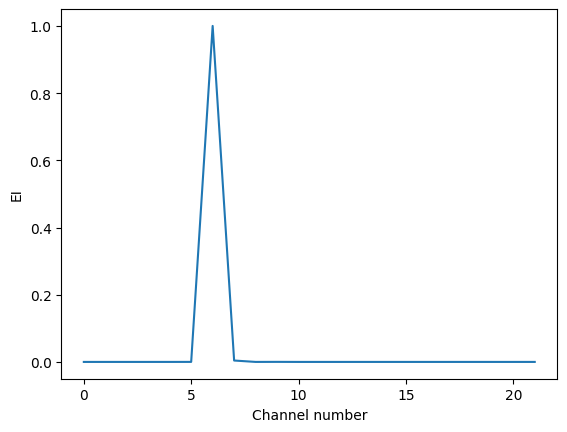

In [ ]:
#Ploting the EI values for every channel
#Divide by max value to normalize between 0 and 1
Ei_n=Ei/np.max(Ei)
plt.plot(Ei_n)
plt.xlabel('Channel number')
plt.ylabel('EI')
plt.show()


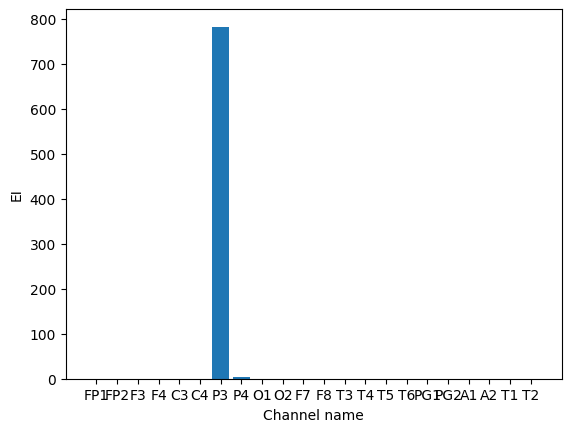

In [ ]:
#Plting a barplt of the EI values for every channel
plt.bar(channels,Ei)
plt.xlabel('Channel name')
plt.ylabel('EI')
plt.show()